In [87]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as pl
import seaborn as sns
sns.set_style('darkgrid')
from wordcloud import WordCloud,STOPWORDS
import spacy as sp
import string
import nltk
import re
import plotly.express as ex
import plotly.graph_objs as go
import plotly.offline as pyo
from plotly.subplots import make_subplots
pyo.init_notebook_mode()
nltk.download('vader_lexicon')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
# nlps = sp.load('en')

def RMSE(y,yh):
    return np.sqrt(mean_squared_error(y,yh))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rissu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [88]:
d_data =pd.read_csv('drake_data.csv',usecols=['album','lyrics_title','lyrics','track_views'])
d_data.head(4)

album                           lyrics_title  \
0  Certified Lover Boy            Certified Lover Boy* Lyrics   
1  Certified Lover Boy  Like I’m Supposed To/Do Things Lyrics   
2  Certified Lover Boy                      Not Around Lyrics   
3  Certified Lover Boy    In the Cut (Ft. Roddy Ricch) Lyrics   

                                              lyrics track_views  
0  [Verse]\nPut my feelings on ice\nAlways been a...        8.7K  
1  [Verse]\nHands are tied\nSomeone's in my ear f...       38.8K  
2  [Intro]\nYeah, we back\nWassup ladies?\nSwisha...      129.8K  
3  [Intro: Drake]\nAyy, yeah\nPipe this shit up a...       72.1K

In [89]:
preprocessed = d_data.copy()
for col in preprocessed.columns[:-1]:
    preprocessed[col]=preprocessed[col].str.lower()
    
preprocessed.head()

album                           lyrics_title  \
0  certified lover boy            certified lover boy* lyrics   
1  certified lover boy  like i’m supposed to/do things lyrics   
2  certified lover boy                      not around lyrics   
3  certified lover boy    in the cut (ft. roddy ricch) lyrics   
4  certified lover boy  zodiac sign (ft. jessie reyez) lyrics   

                                              lyrics track_views  
0  [verse]\nput my feelings on ice\nalways been a...        8.7K  
1  [verse]\nhands are tied\nsomeone's in my ear f...       38.8K  
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...      129.8K  
3  [intro: drake]\nayy, yeah\npipe this shit up a...       72.1K  
4  [verse 1: drake]\nyou ask how many girls i bee...       54.8K

In [90]:
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x: x.replace('lyrics',''))
preprocessed['is_demo'] = preprocessed.lyrics_title.apply(lambda x: 1 if x.find('(demo)') != -1 else 0)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x: x.replace('(demo)',''))
preprocessed.head()

album                     lyrics_title  \
0  certified lover boy            certified lover boy*    
1  certified lover boy  like i’m supposed to/do things    
2  certified lover boy                      not around    
3  certified lover boy    in the cut (ft. roddy ricch)    
4  certified lover boy  zodiac sign (ft. jessie reyez)    

                                              lyrics track_views  is_demo  
0  [verse]\nput my feelings on ice\nalways been a...        8.7K        0  
1  [verse]\nhands are tied\nsomeone's in my ear f...       38.8K        0  
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...      129.8K        0  
3  [intro: drake]\nayy, yeah\npipe this shit up a...       72.1K        0  
4  [verse 1: drake]\nyou ask how many girls i bee...       54.8K        0

In [91]:
preprocessed[preprocessed['is_demo']==1]

album                            lyrics_title  \
262  unreleased songs                            successful     
271  unreleased songs                  desires  (ft. future)    
272  unreleased songs            from time  (ft. jhené aiko)    
274  unreleased songs         pain 1993  (ft. playboi carti)    
276  unreleased songs                               my love     
280  unreleased songs                too good  (ft. rihanna)    
285  unreleased songs            pop style  (ft. kanye west)    
286  unreleased songs               time flies  (ft. future)    
287  unreleased songs  walk it talk it  by quavo (ft. drake)    
288  unreleased songs         god’s plan  (ft. trippie redd)    

                                                lyrics track_views  is_demo  
262  [intro: drake]\nalright well, um, alright. we....        9.4K        1  
271  [intro: future]\nput that christian dior on a ...        7.7K        1  
272  [intro: jhené aiko]\nwhat's up?\nbeen a minute...       13.1K        1  
274  lyrics from snippets\n\n[chorus: drake & playb...         NaN        1  
276  [verse 1]\ni had an idea in my head\ni picture...         NaN        1  
280  [refrain 1: rihanna]\ni don't know how to talk...         NaN        1  
285  lyrics from cut studio recording\n\n[verse 1: ...         NaN        1  
286  lyrics from snippet\n\n[chorus: drake & future...         NaN        1  
287  [intro: quavo]\nyeah, yeah\n(deko)\nwoah, hold...         NaN        1  
288  [intro: drake]\nthey wishing, they wishing, th...         NaN        1

In [92]:
def extract_feat(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find('ft.') != -1:
        return artist.replace('ft. ','')
    else:
        return 'solo'
    
extract_feat(preprocessed['lyrics_title'][100])

'dvsn & pimp c'

In [93]:
extract_feat(preprocessed['lyrics_title'][0])

'solo'

In [94]:
preprocessed['lyrics_title'][100]

'faithful (ft. dvsn & pimp c) '

In [95]:
def remove_artist(s):
    artist = s[s.find("(")+1:s.find(")")]
    if artist.find('ft.') != -1:
        return s[:s.find("(")]
    else:
        return s
    

In [96]:
remove_artist(preprocessed["lyrics_title"][100])

'faithful '

In [97]:
preprocessed['lyrics_title'][100]

'faithful (ft. dvsn & pimp c) '

In [98]:
preprocessed['featuring'] = preprocessed.lyrics_title.apply(extract_feat)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(remove_artist)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(remove_artist)
preprocessed.lyrics_title = preprocessed.lyrics_title.apply(lambda x:re.sub(r'[^\w\s]', '', x) )
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics track_views  is_demo  \
0  [verse]\nput my feelings on ice\nalways been a...        8.7K        0   
1  [verse]\nhands are tied\nsomeone's in my ear f...       38.8K        0   
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...      129.8K        0   
3  [intro: drake]\nayy, yeah\npipe this shit up a...       72.1K        0   
4  [verse 1: drake]\nyou ask how many girls i bee...       54.8K        0   

      featuring  
0          solo  
1          solo  
2          solo  
3   roddy ricch  
4  jessie reyez

In [99]:
def view_preprocess(s):
    if type(s)!= float:
        if s[-1]=='K':
            return float(s.replace('K',''))*1000
        if s[-1]=='M':
            return float(s.replace('M',''))*10**6

In [100]:
preprocessed.track_views = preprocessed.track_views.apply(view_preprocess)
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0  [verse]\nput my feelings on ice\nalways been a...       8700.0        0   
1  [verse]\nhands are tied\nsomeone's in my ear f...      38800.0        0   
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...     129800.0        0   
3  [intro: drake]\nayy, yeah\npipe this shit up a...      72100.0        0   
4  [verse 1: drake]\nyou ask how many girls i bee...      54800.0        0   

      featuring  
0          solo  
1          solo  
2          solo  
3   roddy ricch  
4  jessie reyez

In [101]:
preprocessed['number_of_verses']=0
preprocessed['number_of_chorus']=0
preprocessed.loc[preprocessed.lyrics.notna().index,'number_of_verses'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r'verse',x)))
preprocessed.loc[preprocessed.lyrics.notna().index,'number_of_chorus'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:len( re.findall(r'chorus',x)))

In [102]:
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0  [verse]\nput my feelings on ice\nalways been a...       8700.0        0   
1  [verse]\nhands are tied\nsomeone's in my ear f...      38800.0        0   
2  [intro]\nyeah, we back\nwassup ladies?\nswisha...     129800.0        0   
3  [intro: drake]\nayy, yeah\npipe this shit up a...      72100.0        0   
4  [verse 1: drake]\nyou ask how many girls i bee...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  
0          solo               1.0               0.0  
1          solo               1.0               2.0  
2          solo               2.0               3.0  
3   roddy ricch               2.0               2.0  
4  jessie reyez               2.0               0.0

In [103]:
a="Rishav"
a[a.find("i")+1:a.find("v")]

'sha'

In [104]:
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: re.sub(r'\[([^]]*)]','',x))
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x: x.replace('\n',' '))
preprocessed.loc[preprocessed.lyrics.notna().index,'lyrics'] = preprocessed.lyrics[preprocessed.lyrics.notna()].apply(lambda x:re.sub(r'[^\w\s]', '', x))

In [105]:
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   
3   ayy yeah pipe this shit up and i turn this sh...      72100.0        0   
4   you ask how many girls i been with in my life...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  
0          solo               1.0               0.0  
1          solo               1.0               2.0  
2          solo               2.0               3.0  
3   roddy ricch               2.0               2.0  
4  jessie reyez               2.0               0.0

In [106]:

sid = SIA()
preprocessed['lyrics']=preprocessed['lyrics'].astype('str')
preprocessed['sentiments'] = preprocessed['lyrics'].apply(lambda x: sid.polarity_scores(x))
preprocessed['Positive Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['pos']) 
preprocessed['Neutral Sentiment']    = preprocessed['sentiments'].apply(lambda x: x['neu'])
preprocessed['Negative Sentiment']   = preprocessed['sentiments'].apply(lambda x: x['neg'])
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   
3   ayy yeah pipe this shit up and i turn this sh...      72100.0        0   
4   you ask how many girls i been with in my life...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  \
0          solo               1.0               0.0   
1          solo               1.0               2.0   
2          solo               2.0               3.0   
3   roddy ricch               2.0               2.0   
4  jessie reyez               2.0               0.0   

                                          sentiments  Positive Sentiment  \
0  {'neg': 0.133, 'neu': 0.708, 'pos': 0.158, 'co...               0.158   
1  {'neg': 0.067, 'neu': 0.79, 'pos': 0.143, 'com...               0.143   
2  {'neg': 0.18, 'neu': 0.751, 'pos': 0.069, 'com...               0.069   
3  {'neg': 0.114, 'neu': 0.714, 'pos': 0.172, 'co...               0.172   
4  {'neg': 0.098, 'neu': 0.723, 'pos': 0.179, 'co...               0.179   

   Neutral Sentiment  Negative Sentiment  
0              0.708               0.133  
1              0.790               0.067  
2              0.751               0.180  
3              0.714               0.114  
4              0.723               0.098

In [107]:
preprocessed.drop(columns=['sentiments'],inplace=True)

preprocessed['# Of Words']= preprocessed['lyrics'].apply(lambda x: len(x.split(' ')))
preprocessed['# Of StopWords']= preprocessed['lyrics'].apply(lambda x: len([word for word in x.split(' ') if word in list(STOPWORDS)]))
preprocessed['Average Word Length']= preprocessed['lyrics'].apply(lambda x: np.mean(np.array([len(va) for va in x.split(' ') if va not in list(STOPWORDS)])))
preprocessed['Average Sentence Length']= preprocessed['lyrics'].apply(lambda x: np.mean(np.array([len(va) for va in x.split('.')])))


preprocessed.head(3)

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   

  featuring  number_of_verses  number_of_chorus  Positive Sentiment  \
0      solo               1.0               0.0               0.158   
1      solo               1.0               2.0               0.143   
2      solo               2.0               3.0               0.069   

   Neutral Sentiment  Negative Sentiment  # Of Words  # Of StopWords  \
0              0.708               0.133          21               6   
1              0.790               0.067         180              96   
2              0.751               0.180         566             286   

   Average Word Length  Average Sentence Length  
0             5.200000                    113.0  
1             4.535714                    825.0  
2             4.857143                   2691.0

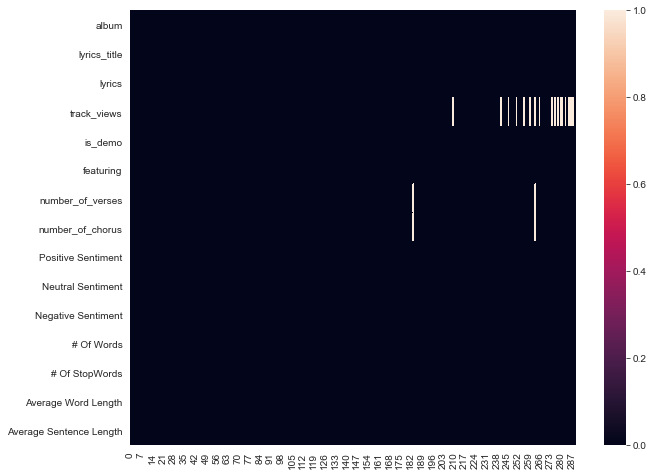

In [108]:
pl.figure(figsize=(10,8))
sns.heatmap(preprocessed.isnull().T)
pl.show()

In [109]:
preprocessed.isna().sum()

album                       0
lyrics_title                0
lyrics                      0
track_views                18
is_demo                     0
featuring                   0
number_of_verses            2
number_of_chorus            2
Positive Sentiment          0
Neutral Sentiment           0
Negative Sentiment          0
# Of Words                  0
# Of StopWords              0
Average Word Length         0
Average Sentence Length     0
dtype: int64

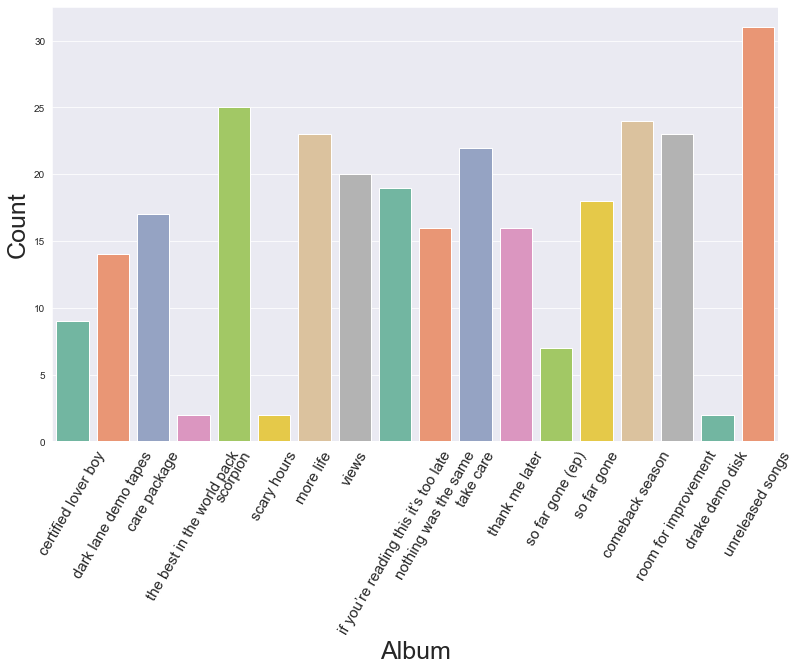

In [110]:
pl.figure(figsize=(13,8))
sns.countplot(preprocessed['album'],palette='Set2')
pl.xticks(rotation=60,fontsize=15)
pl.xlabel("Album",fontsize=25)
pl.ylabel("Count",fontsize=25)
pl.show()

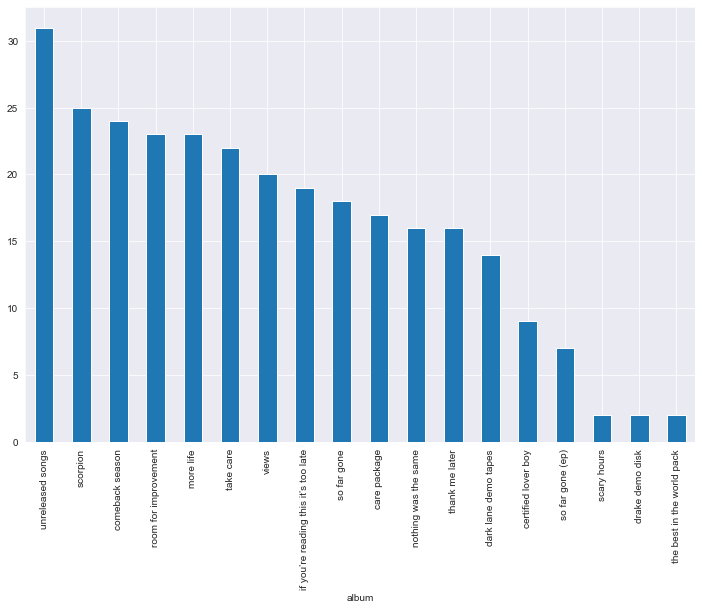

In [111]:
preprocessed.groupby('album')['album'].size().sort_values(ascending=False).plot(kind='bar',figsize=(12,8))

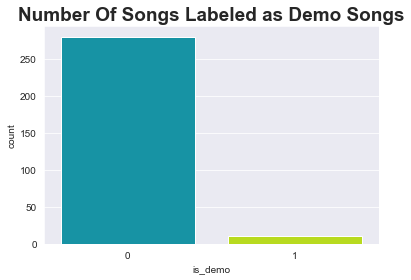

In [112]:
pl.title('Number Of Songs Labeled as Demo Songs',fontsize=19,fontweight='bold')
ax = sns.countplot(preprocessed.is_demo,palette='nipy_spectral')
pl.show()

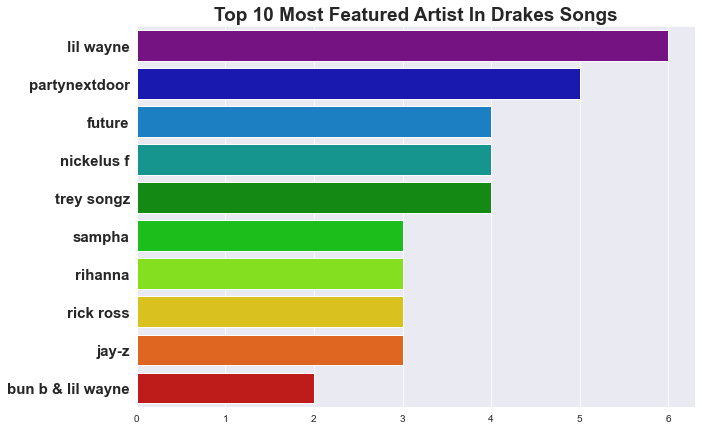

In [113]:
pl.figure(figsize=(10,7))
pl.title('Top 10 Most Featured Artist In Drakes Songs',fontsize=19,fontweight='bold')
ax=sns.barplot(y=preprocessed.featuring.value_counts()[1:11].index,x=preprocessed.featuring.value_counts()[1:11].values,palette='nipy_spectral')
ax.set_yticklabels(ax.get_yticklabels(),fontsize=15,fontweight='bold')
pl.show()

In [114]:
preprocessed.head()

album                   lyrics_title  \
0  certified lover boy           certified lover boy    
1  certified lover boy  like im supposed todo things    
2  certified lover boy                    not around    
3  certified lover boy                    in the cut    
4  certified lover boy                   zodiac sign    

                                              lyrics  track_views  is_demo  \
0   put my feelings on ice always been a gem cert...       8700.0        0   
1   hands are tied someones in my ear from the ot...      38800.0        0   
2   yeah we back wassup ladies swishahouse baby w...     129800.0        0   
3   ayy yeah pipe this shit up and i turn this sh...      72100.0        0   
4   you ask how many girls i been with in my life...      54800.0        0   

      featuring  number_of_verses  number_of_chorus  Positive Sentiment  \
0          solo               1.0               0.0               0.158   
1          solo               1.0               2.0               0.143   
2          solo               2.0               3.0               0.069   
3   roddy ricch               2.0               2.0               0.172   
4  jessie reyez               2.0               0.0               0.179   

   Neutral Sentiment  Negative Sentiment  # Of Words  # Of StopWords  \
0              0.708               0.133          21               6   
1              0.790               0.067         180              96   
2              0.751               0.180         566             286   
3              0.714               0.114         339             169   
4              0.723               0.098         446             236   

   Average Word Length  Average Sentence Length  
0             5.200000                    113.0  
1             4.535714                    825.0  
2             4.857143                   2691.0  
3             4.658824                   1592.0  
4             5.200000                   2206.0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

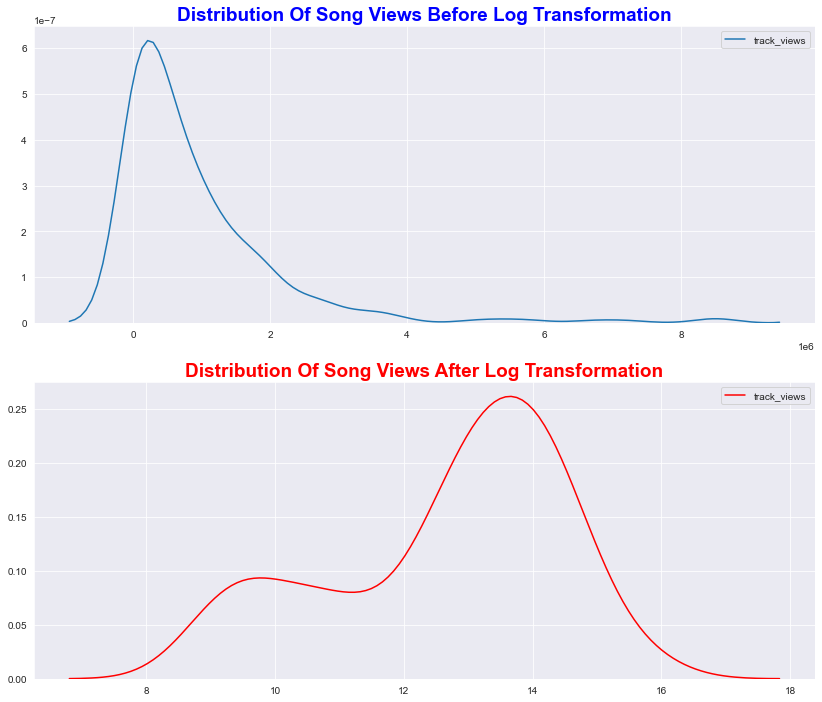

In [115]:
pl.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.title('Distribution Of Song Views Before Log Transformation',fontsize=19,fontweight='bold',color='b')
sns.kdeplot(preprocessed.track_views)
plt.subplot(2,1,2)
plt.title('Distribution Of Song Views After Log Transformation',fontsize=19,fontweight='bold',color='r')
sns.kdeplot(np.log(preprocessed.track_views),color='r')
plt.show()

<Figure size 1080x720 with 0 Axes>

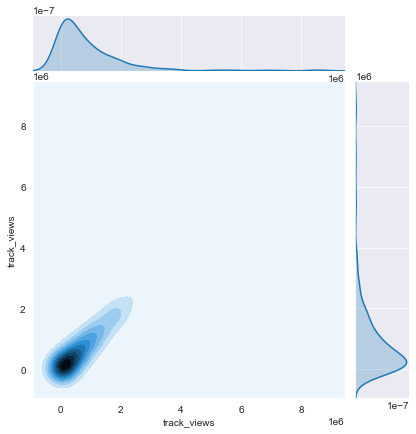

In [116]:
pl.figure(figsize=(15,10))
sns.jointplot(preprocessed.track_views,preprocessed.track_views,kind='kde')
pl.show()

<Figure size 1080x720 with 0 Axes>

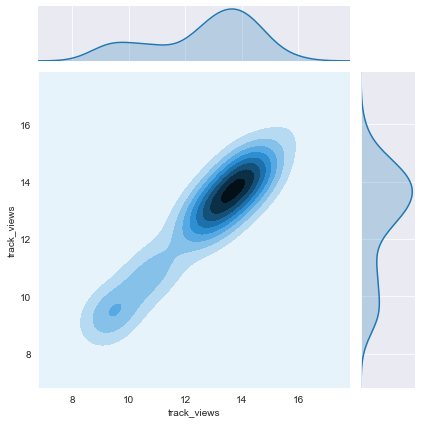

In [117]:
pl.figure(figsize=(15,10))
sns.jointplot(np.log(preprocessed.track_views),np.log(preprocessed.track_views),kind='kde')
pl.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

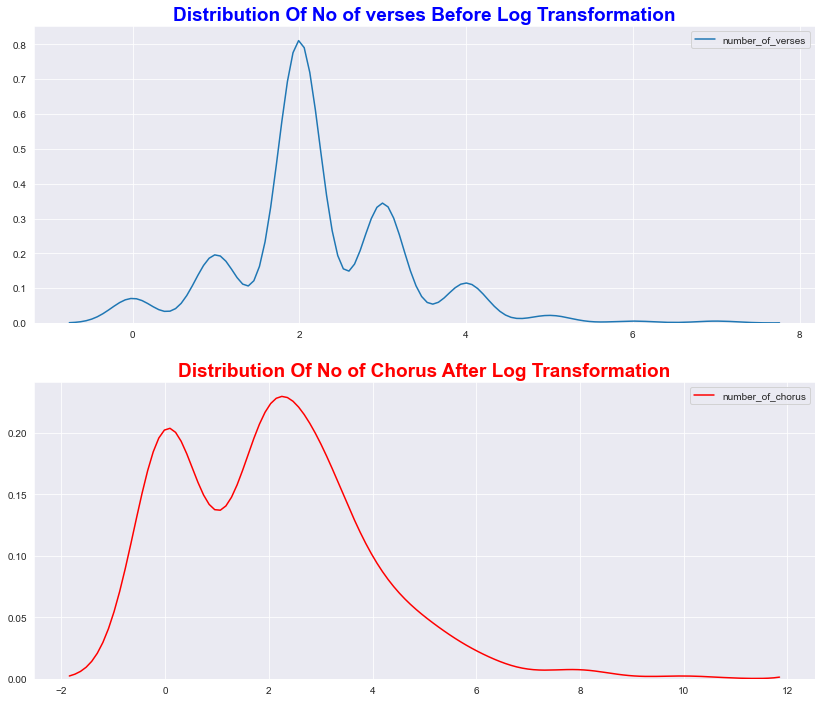

In [120]:
pl.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.title('Distribution Of No of verses Before Log Transformation',fontsize=19,fontweight='bold',color='b')
sns.kdeplot(preprocessed.number_of_verses)
plt.subplot(2,1,2)
plt.title('Distribution Of No of Chorus After Log Transformation',fontsize=19,fontweight='bold',color='r')
sns.kdeplot(preprocessed.number_of_chorus,color='r')
plt.show()

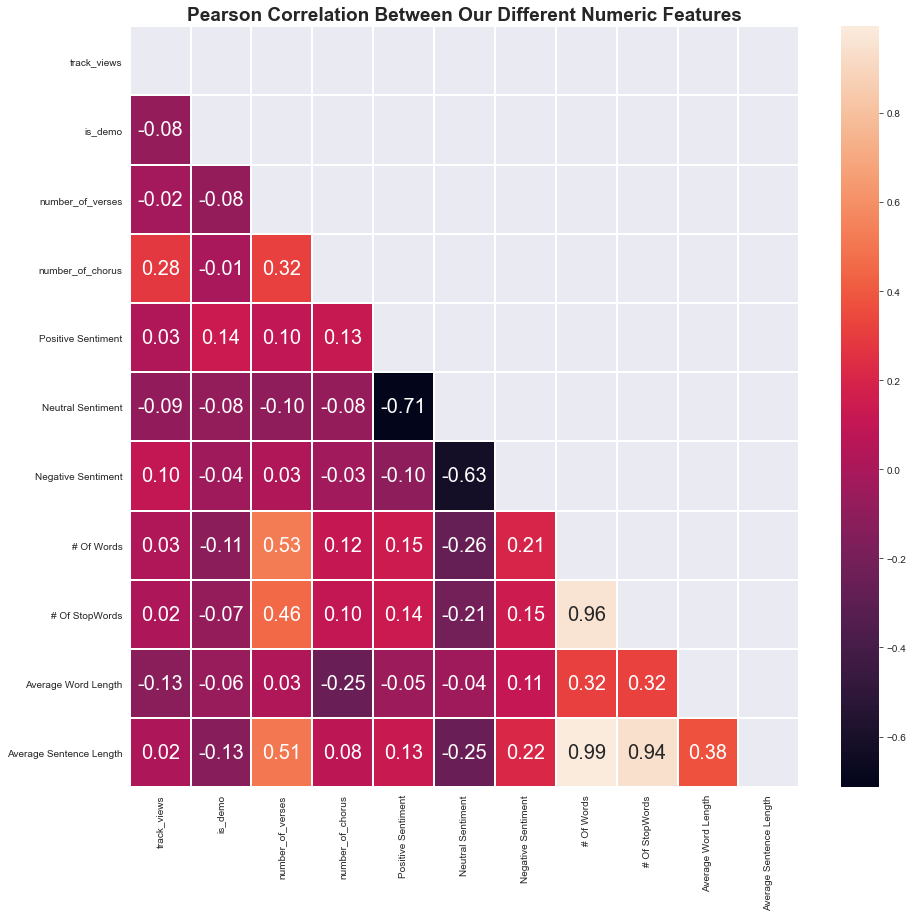

In [136]:
pl.figure(figsize=(15,14))
pl.title('Pearson Correlation Between Our Different Numeric Features',fontsize=19,fontweight='bold')
sns.heatmap(preprocessed.corr(),annot=True,mask=np.triu(np.ones((11,11))),annot_kws={"size": 20},
           linewidth=1,edgecolor='k',fmt='.2f')
pl.show()

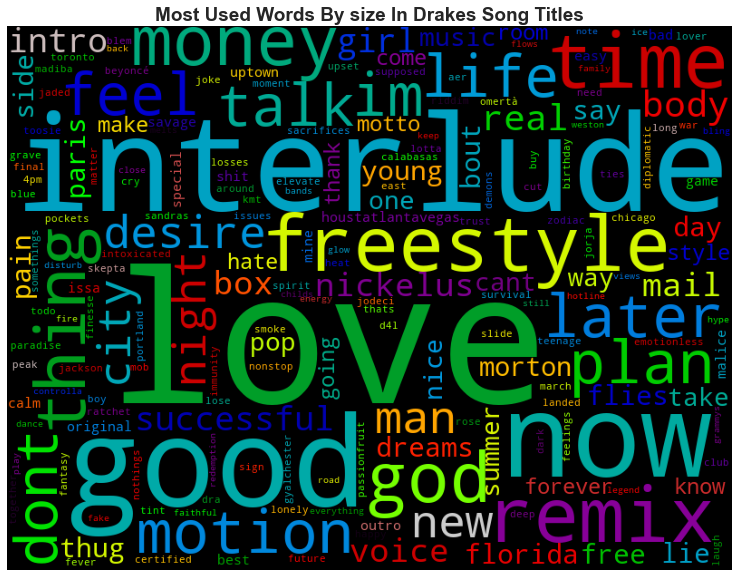

In [151]:
l_t = ' '.join(preprocessed.lyrics_title).strip().replace('drake','')
l_t = l_t.replace('ft','')
w_c = WordCloud(width=800,height=600,collocations = False,stopwords=STOPWORDS,colormap='nipy_spectral').generate(l_t)
pl.figure(figsize=(14,10))

pl.title('Most Used Words By size In Drakes Song Titles',fontsize=19,fontweight='bold')
pl.imshow(w_c)
pl.axis('off')
pl.show()

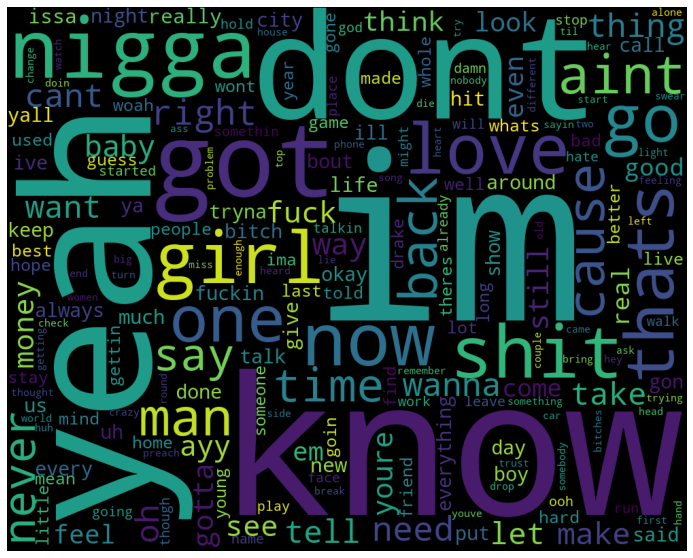

In [153]:
txt=' '.join(preprocessed.lyrics).strip()
pl.figure(figsize=(14,10))
wc=WordCloud(width=1000,height=800,stopwords=STOPWORDS,collocations=False).generate(txt)
pl.axis('off')
pl.imshow(wc)
pl.show()

In [215]:
no_of_components=1000
len(preprocessed)

290

In [216]:
x=CountVectorizer().fit_transform(preprocessed.lyrics)
x

<290x8718 sparse matrix of type '<class 'numpy.int64'>'
	with 57335 stored elements in Compressed Sparse Row format>

In [217]:
x.toarray().shape

(290, 8718)

In [218]:
svd=TruncatedSVD(no_of_components)
dec_matrix=svd.fit_transform(x)

In [219]:
ex_var=svd.explained_variance_ratio_

In [220]:
dec_matrix.shape

(290, 290)

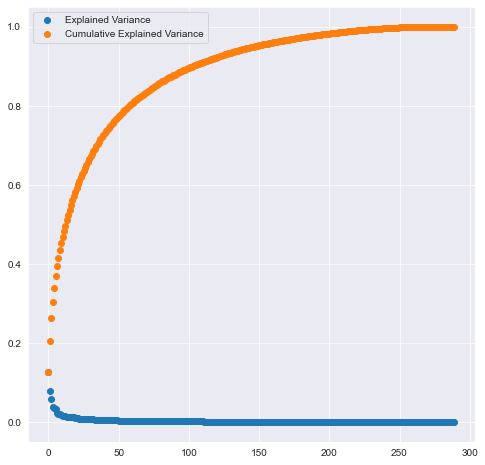

In [221]:
pl.figure(figsize=(8,8))
pl.scatter(np.arange(len(ex_var)),ex_var,label='Explained Variance')
pl.scatter(np.arange(len(ex_var)),np.cumsum(ex_var),label='Cumulative Explained Variance')
pl.legend()
pl.show()

In [222]:
len(ex_var)

290